In [1]:
import sys
sys.path.append("../")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

#### Experiment Configs

In [4]:
root_path = "/scratch/saksham/data/freiburg_small/" # Fern Dataset path on my local
img_wh = (504, 378)
N_importance = 64
N_samples = 64
use_disp = False
chunk = 1024*32*4

In [5]:
from datasets import dataset_dict
from datasets.llff import *

dataset = dataset_dict['llff_tum'](
              root_path,
              start = 0,
              end = 30,
              split = "val",
              img_wh = img_wh,
              spheric_poses = False,
              val_num = 4
          )

val image is /scratch/saksham/data/freiburg_small/images/1305031454.827570.png


In [6]:
# take a sample from the validation set
index = 0
sample = dataset[index]
rays = sample['rays']
rays.shape

torch.Size([190512, 8])

#### Define Models

In [7]:
from models.nerf import Embedding, NeRF

In [8]:
# Embeds x to (x, sin(2^k x), cos(2^k x), ...) 
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

# Encodes input (xyz+dir) to rgb+sigma (not ready to render yet)
nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = "../ckpts/freiburg_small_1/epoch=27.ckpt"

In [9]:
load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

In [10]:
nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [11]:
models = {'coarse': nerf_coarse, 'fine': nerf_fine}
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}

#### Rendering 

In [12]:
# rendering params
N_importance = 64 # number of fine samples per ray
N_samples = 64 # number of coarse samples per ray
use_disp = False # whether to sample in disparity space (inverse depth)
perturb = False # factor to perturb the sampling position on the ray (for coarse model only)
noise_std = 1.0  # factor to perturb the model's prediction of sigma
chunk = 1024*32*4
test_time = True
white_back = dataset.white_back

In [13]:
from models.rendering import *
from models.nerf import *

@torch.no_grad()
def f(rays):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [14]:
sample = dataset[0]
rays = sample['rays'].cuda()

t = time.time()
results = f(rays)
torch.cuda.synchronize()
print(time.time()-t)

56.85366916656494


In [15]:
results['depth_fine'].shape

torch.Size([190512])

PSNR 32.62487030029297


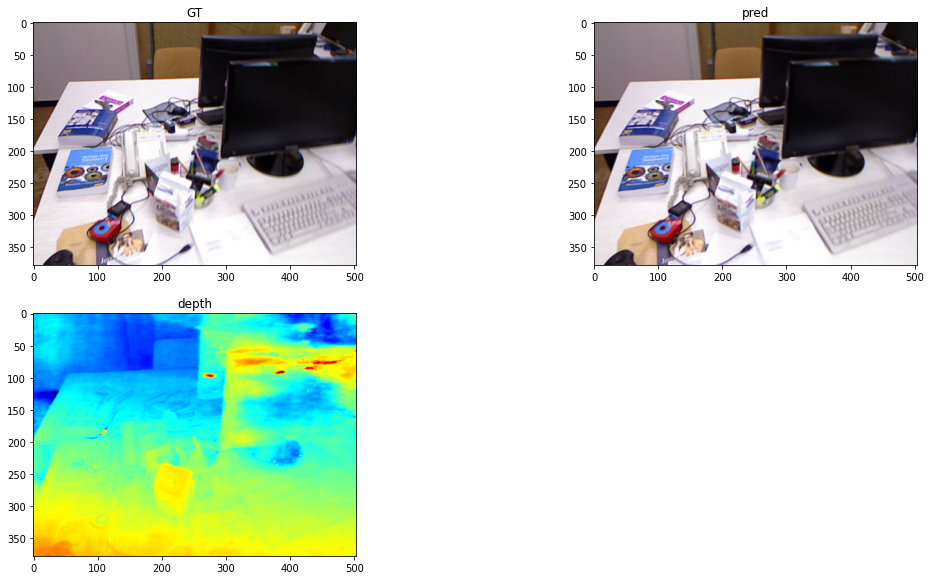

In [16]:
import metrics

img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_gt = sample['depths'].view(img_wh[1], img_wh[0])
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()
 

In [17]:
from utils.visualization import visualize_depth

In [21]:
depth_color_map = visualize_depth(depth_gt, return_PIL = True)

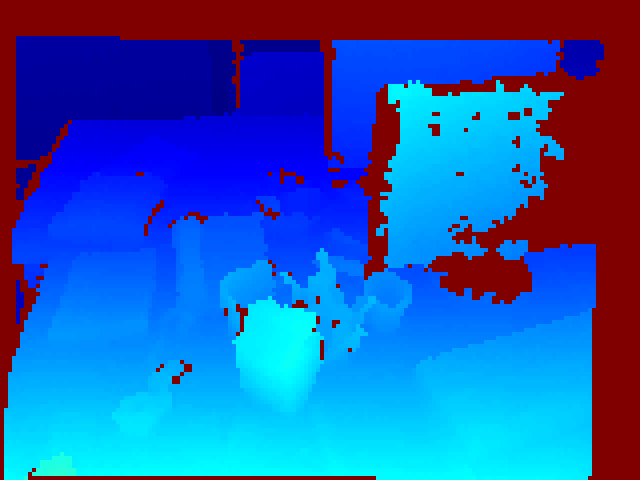

In [27]:
import PIL

depth_color_map.resize((160,120), resample = PIL.Image.NEAREST).resize((640,480), resample = PIL.Image.NEAREST)

(array([[  0.,   0.,  23., ..., 104.,  11.,   0.],
        [  0.,   0.,  23., ..., 102.,  12.,   0.],
        [  0.,   0.,  23., ..., 101.,  12.,   0.],
        ...,
        [  0.,   0.,   2., ...,  19.,   0.,   0.],
        [  0.,   0.,   4., ...,  18.,   0.,   0.],
        [  0.,   3.,   6., ...,  15.,   0.,   0.]]),
 array([0.69025004, 0.71921915, 0.7481883 , 0.7771574 , 0.80612653,
        0.83509564, 0.8640648 , 0.8930339 , 0.92200303, 0.9509722 ,
        0.9799413 ], dtype=float32),
 <a list of 504 BarContainer objects>)

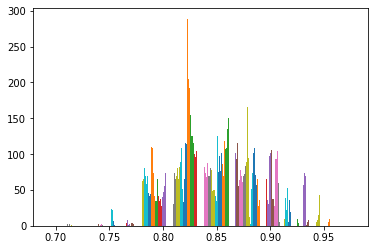

In [18]:
plt.hist(depth_pred.cpu().numpy())

(array([[378.,   0.,   0., ...,   0.,   0.,   0.],
        [378.,   0.,   0., ...,   0.,   0.,   0.],
        [359.,   0.,   4., ...,   0.,   0.,   0.],
        ...,
        [378.,   0.,   0., ...,   0.,   0.,   0.],
        [378.,   0.,   0., ...,   0.,   0.,   0.],
        [378.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0.25      , 0.31912032, 0.3882406 , 0.45736092, 0.5264812 ,
        0.59560156, 0.66472185, 0.73384213, 0.8029624 , 0.87208277,
        0.94120306], dtype=float32),
 <a list of 504 BarContainer objects>)

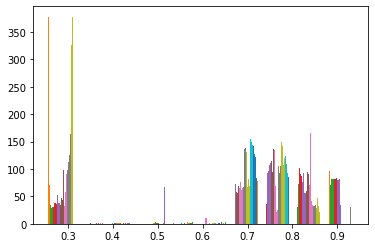

In [20]:
plt.hist(depth_gt.cpu().numpy()


In [21]:
depth = 1/(1-depth_pred)

In [22]:
depth = depth.cpu().numpy()

(array([[185., 181.,  12., ...,   0.,   0.,   0.],
        [186., 180.,  12., ...,   0.,   0.,   0.],
        [188., 177.,  13., ...,   0.,   0.,   0.],
        ...,
        [339.,  39.,   0., ...,   0.,   0.,   0.],
        [338.,  40.,   0., ...,   0.,   0.,   0.],
        [339.,  39.,   0., ...,   0.,   0.,   0.]]),
 array([ 3.2284105,  7.890939 , 12.553468 , 17.215998 , 21.878527 ,
        26.541054 , 31.203583 , 35.86611  , 40.52864  , 45.19117  ,
        49.8537   ], dtype=float32),
 <a list of 504 BarContainer objects>)

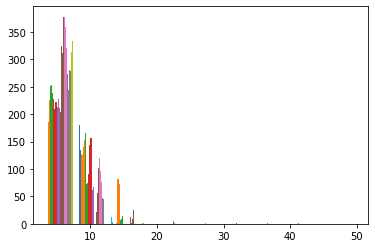

In [23]:
plt.hist(depth)

In [54]:
np.percentile(depth, 95)

22.341186904907225

In [55]:
np.percentile(depth,5)

8.713369512557984

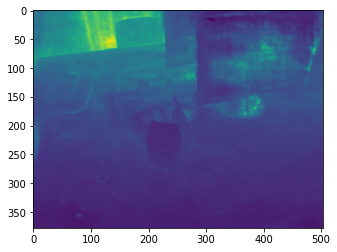

In [56]:
plt.imshow(depth)

In [51]:
depth

array([[8.70146  , 8.554532 , 8.4618025, ..., 5.9887104, 6.1005616,
        6.3901715],
       [8.760912 , 8.640166 , 8.522821 , ..., 6.082794 , 6.17825  ,
        6.3746033],
       [8.724424 , 8.658458 , 8.596022 , ..., 5.9526963, 6.119277 ,
        6.2749624],
       ...,
       [4.268135 , 4.281242 , 4.290803 , ..., 4.1162233, 4.1199493,
        4.1068044],
       [4.2732916, 4.276033 , 4.2784023, ..., 4.098716 , 4.0936475,
        4.058852 ],
       [4.2722197, 4.27837  , 4.27962  , ..., 4.0888724, 4.0890217,
        4.051657 ]], dtype=float32)